# Text Mining Project
#### Spring 2022
#### Opinion Mining Evaluation Forum
#### Students m20200246 Pedro Costa, m20181034 Ana Bernardes & m20211001 Miguel Ova

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('stopwords')

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
stem = SnowballStemmer("english")

## Importing machine learning packages
# Estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Machines cannot process the raw text data, it has to be converted into a matrix of numbers
# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#For calculating the accuracy score of our model during prediction
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, f1_score, confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data import

In [2]:
## Loading files
df_train = pd.read_csv('training_set.txt', delimiter = '\t')
df_test = pd.read_csv('test_set.txt', delimiter = '\t')
df_dev = pd.read_csv('dev_set.txt', delimiter = '\t')

## Append train_set and dev_set for a bigger training sample
df1 = df_train.append(df_dev, ignore_index=True)
df2 = df_test
df3 = df_train
df4 = df_dev

### Classe name to be used in the  Confusion Matrix
class_names = df1['emotion'].unique().tolist()

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_9560\3254970174.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df_train.append(df_dev, ignore_index=True)


In [3]:
# Preview of train data
df1.head()

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


In [4]:
# Size of train data
len(df1)

15000

In [5]:
# Checking for null/empty cells
df1.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [6]:
# Value count of each emotion
df1['emotion'].value_counts()

1    3210
2    2299
8    2253
5    1567
4    1546
6    1471
3    1420
7    1234
Name: emotion, dtype: int64

In [7]:
# Word Count
def word_count(text):
    """
    Function that counts text words
    """
    df1_words = " ".join(text).split()
    # Count all words 
    freq = pd.Series(df1_words).value_counts()
    return freq

In [8]:
word_count(list(df1['sentence']))[:25]

.           11334
,            6118
you          3736
I            3446
to           3085
?            2907
the          2890
a            2480
!            1728
[PERSON]     1487
of           1459
and          1341
it           1292
me           1271
that         1227
in           1155
You          1025
is            969
for           908
be            817
this          804
I'm           787
have          771
your          726
my            722
dtype: int64

In [9]:
### Preprocessing
!pip install neattext
import neattext.functions as nfx
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [10]:
df1['sentence'] = df1['sentence'].apply(nfx.remove_stopwords)

In [11]:
word_count(list(df1['sentence']))[:25]

.             11334
,              6118
?              2907
!              1728
[PERSON]       1487
I'm             787
...             676
know            572
like            541
-               493
got             414
want            399
think           340
I'll            326
right           316
good            310
[LOCATION]      307
gonna           293
going           277
time            240
man             226
That's          219
come            217
can't           217
Oh              215
dtype: int64

In [12]:
### function to clean dataframe
def clean(text_in, lemmatize, stemmer):
    """
    Preprocessing function will consist of   
    - make everything lowercased
    - removing all symbols that are not letters
    - remove stopwords
    - replace words with the corresponding lemma or stem
    """
    updates = []
    for j in tqdm(range(len(text_in))):
        
        text = text_in[j]
        
        #make everything lowercased
        text = text.lower()      
          
        #removing all symbols that are not letters
        text = re.sub("[^a-zA-Z]", ' ', text)
            
        #remove stopwords
        #text = ' '.join([word for word in text.split() if word not in stop])
        
        #replace words with the corresponding lemma
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(stem.stemmer(word) for word in text.split())
        
        updates.append(text)
        
    return updates

In [13]:
### function to update dataframe
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"sentence": list_updated}))

In [14]:
updates = clean(df1["sentence"], lemmatize = True, stemmer = False)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_9560\2950840024.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_in))):


  0%|          | 0/15000 [00:00<?, ?it/s]

In [15]:
update_df(df1, updates)
df1

,sentence,emotion
0,i m old traded,6
1,mother said tell lady hand,8
2,said i d leave time came,6
3,he ll safe,2
4,lay,1
...,...,...
14995,ask careful,4
14996,like jazz pal,7
14997,,1
14998,imagine person spot like,7


In [16]:
df1.isnull().sum()

sentence    0
emotion     0
dtype: int64

### Training the Logistic Regression Model with train_set + dev_set

In [17]:
##Defining features and labels
#Features are the attributes and variables extracted from the dataset. These extracted features are used as inputs to the model during training enabling model learning. Our features are present in the clean_sentence column.
Xfeatures = df1['sentence']
ylabels = df1['emotion']

In [18]:
#  Split Data
X_train, X_test, y_train, y_test = train_test_split(Xfeatures,ylabels,test_size=0.2,random_state=42)

In [19]:
##Making the process of training our model faster and automated, we will use a machine learning pipeline. Machine learning pipelines automate the machine learning workflows such as model fitting and training.
from sklearn.pipeline import Pipeline

In [20]:
# LogisticRegression Pipeline
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

In [21]:
#Model fitting
pipe_lr.fit(X_train, y_train)


C:\Users\Utilizador\anaconda3\envs\TM_Lab\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [22]:
pipe_lr

Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [23]:
y_pred = pipe_lr.predict(X_test)

### Dev_set prep for evaluation (REPORT ONLY)

In [24]:
df3['sentence'] = df3['sentence'].apply(nfx.remove_stopwords)

In [25]:
updates_3 = clean(df3["sentence"], lemmatize = True, stemmer = False)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_9560\2950840024.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_in))):


  0%|          | 0/14000 [00:00<?, ?it/s]

In [26]:
update_df(df3, updates_3)
df3

,sentence,emotion
0,i m old traded,6
1,mother said tell lady hand,8
2,said i d leave time came,6
3,he ll safe,2
4,lay,1
...,...,...
13995,yes commissioner,8
13996,ring,7
13997,greatest enduring love,5
13998,came war son,5


In [27]:
df3.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [28]:
Xfeatures_3 = df3['sentence']
ylabels_3 = df3['emotion']

In [29]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(Xfeatures_3 ,ylabels_3 ,test_size=0.2,random_state=42)

In [30]:
pipe_lr_3 = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

In [31]:
pipe_lr_3.fit(X_train_3, y_train_3)

C:\Users\Utilizador\anaconda3\envs\TM_Lab\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [32]:
pipe_lr_3

Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [33]:
#### dev_set clean to predict emotion
df4['sentence'] = df4['sentence'].apply(nfx.remove_stopwords)

In [34]:
updates_4 = clean(df4["sentence"], lemmatize = True, stemmer = False)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_9560\2950840024.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_in))):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
update_df(df4, updates_4)
df4

,sentence,emotion
0,happens gold safe,4
1,natural cold foot,8
2,lucky,7
3,i m little anxious whoop et s as that s,2
4,think know affair government official,1
...,...,...
995,ask careful,4
996,like jazz pal,7
997,,1
998,imagine person spot like,7


In [36]:
X_test_3 = df4["sentence"]

In [37]:
y_test_3 = df4["emotion"]

In [38]:
y_pred_3 = pipe_lr_3.predict(X_test_3)

In [39]:
df4["emotion"] = y_pred_3

In [40]:
df4

,sentence,emotion
0,happens gold safe,8
1,natural cold foot,6
2,lucky,5
3,i m little anxious whoop et s as that s,3
4,think know affair government official,1
...,...,...
995,ask careful,4
996,like jazz pal,8
997,,1
998,imagine person spot like,2


In [41]:
### save to file
df4.to_csv('dev_results.txt.txt', header=True, sep ='\t', index =False)

##### Evaluation

In [42]:
# Function to plot a confusion Matrix with true emotion and predicted emotion
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [43]:
##### Evaluation of the dev_set only
print("Classification report dev_set:\n",classification_report(y_test_3, y_pred_3, labels = class_names))

Classification report dev_set:
               precision    recall  f1-score   support

           6       0.32      0.25      0.28        87
           8       0.33      0.30      0.31       158
           2       0.36      0.37      0.37       170
           1       0.35      0.59      0.44       211
           4       0.39      0.29      0.33       104
           5       0.37      0.34      0.35        97
           3       0.28      0.16      0.20        77
           7       0.43      0.24      0.31        96

    accuracy                           0.35      1000
   macro avg       0.35      0.32      0.32      1000
weighted avg       0.36      0.35      0.34      1000




Confusion Matrix dev_set:
 [[124  23  11  14   4  13   6  16]
 [ 45  63   6   8  12   5   8  23]
 [ 33  14  12   3   3   4   1   7]
 [ 32   9   3  30   4   7   3  16]
 [ 16  17   3   2  33   4   7  15]
 [ 32   9   2   7   8  22   3   4]
 [ 27  15   1   5   5   6  23  14]
 [ 45  24   5   7  20   7   3  47]]


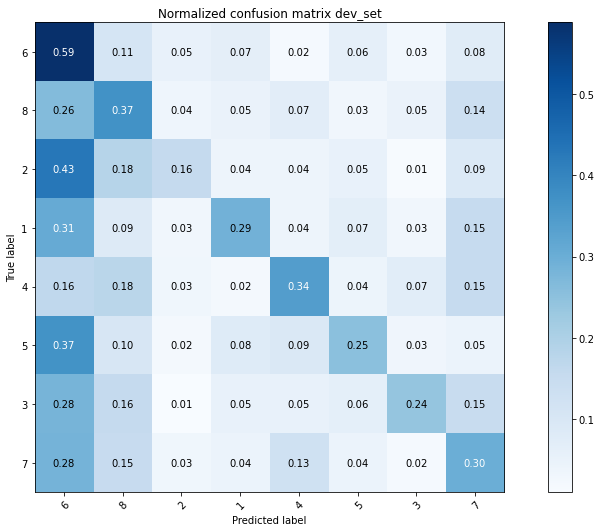

In [44]:
##### Confusion matrix of the dev_set only

print("\nConfusion Matrix dev_set:\n", confusion_matrix(y_test_3, y_pred_3))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_3, y_pred_3, classes=class_names, normalize=True, title='Normalized confusion matrix dev_set')
plt.show()

In [45]:
#### Evaluation of the train_set + dev_set
print("Classification report train_set + dev_set:\n",classification_report(y_test, y_pred, labels = class_names))

Classification report train_set + dev_set:
               precision    recall  f1-score   support

           6       0.37      0.27      0.32       290
           8       0.32      0.34      0.33       432
           2       0.34      0.38      0.36       476
           1       0.35      0.55      0.43       641
           4       0.29      0.25      0.27       297
           5       0.55      0.46      0.50       329
           3       0.33      0.17      0.22       263
           7       0.30      0.13      0.18       272

    accuracy                           0.36      3000
   macro avg       0.36      0.32      0.33      3000
weighted avg       0.36      0.36      0.34      3000



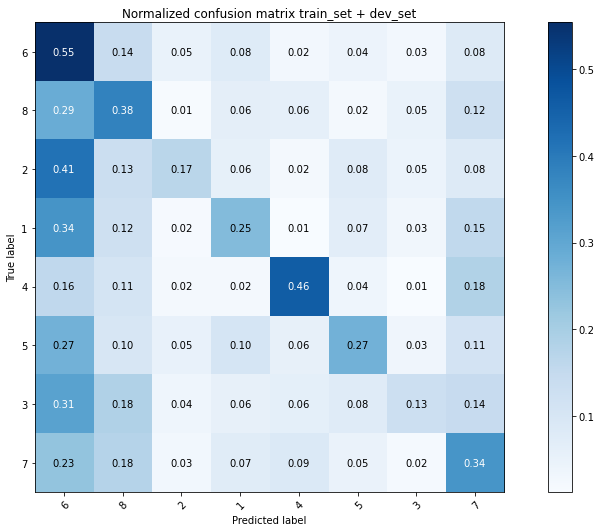

In [46]:
#### Confusion matrix of the train_set + dev_set

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix train_set + dev_set')
plt.show()

### Predict Test_Set Emotion

In [47]:
#Clean Test_set
df2['sentence'] = df2['sentence'].apply(nfx.remove_stopwords)

In [48]:
updates_2 = clean(df2["sentence"], lemmatize = True, stemmer = False)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_9560\2950840024.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_in))):


  0%|          | 0/2000 [00:00<?, ?it/s]

In [49]:
update_df(df2, updates_2)
df2

,sentence
0,come let s automobile
1,time
2,he s trouble boy
3,criminal gang unit control
4,molto discussion interview
...,...
1995,let s good
1996,hey looking good
1997,moved embassy hijacking
1998,


In [50]:
# Checking for null/empty cells
df2.isnull().sum()

sentence    0
dtype: int64

In [51]:
X_test = df2["sentence"]

In [52]:
### emotion prediction
y_pred = pipe_lr.predict(X_test)

In [53]:
df2["emotion"] = y_pred

In [54]:
# Size of train data
len(df2)

2000

In [55]:
# emotion predicted
df2[100:400]

,sentence,emotion
100,real ghost,7
101,trouble like school,4
102,vice president call i ll meet centre aisle,2
103,chilli,1
104,ended pretty good thing,5
...,...,...
395,plan,1
396,close,8
397,herb,1
398,hate villain,1


In [56]:
### save to file
df2.to_csv('test_results.txt', header=True, sep ='\t', index =False)